In [1]:
%%capture
!pip install datasets h5py

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
import optax
import equinox as eqx
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display
from functools import partial
from transforms import utilities
from jax.lax import scan, dot_general
from load_ConDiff import load_ConDiff
from architectures import DilResNet, SNO
from jax import config, random, grad, vmap, jit
from jax.tree_util import tree_map, tree_flatten
from transforms import library_of_transforms as lft

config.update("jax_enable_x64", True)

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
def compute_relative_error(model, features, targets, n, analysis, synthesis):
    prediction = vmap(lambda x: model(x, analysis, synthesis), in_axes=(0,))(features[n])
    relative_error = jnp.linalg.norm((prediction - targets[n]).reshape(n.size, -1), axis=1) / jnp.linalg.norm(targets[n].reshape(n.size, -1), axis=1)
    return relative_error

def train_on_epoch(key, batch_size, model, features, targets, opt_state, make_step):
    N_samples = len(features)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)
    n_batches = N_samples // batch_size
    carry = [model, features, targets, opt_state]
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))
    data, epoch_loss = scan(make_step, carry, n)
    model = data[0]
    opt_state = data[-1]
    return epoch_loss, model, opt_state

def test_on_epoch(key, batch_size, model, features, targets, analysis, synthesis):
    N_samples_test = features.shape[0]
    list_of_indices_test = jnp.linspace(0, N_samples_test-1, N_samples_test, dtype=jnp.int64)
    n_batches_test = N_samples_test // batch_size
    n_test = random.choice(key, list_of_indices_test, shape = (n_batches_test, batch_size))
    loss_test_error = lambda a, ind: (None, SNO.compute_loss(model, features[ind], targets[ind], analysis, synthesis))
    _, test_loss = scan(loss_test_error, None, n_test)
    return jnp.mean(test_loss)

In [5]:
def get_SNO(key, features, grid):
    input = features[0]
    D = len(input.shape[1:])
    
    polynomials = ["Real_Fourier", ] * D
    parameters = [[0.1, 0.1],] * D
    M_keep = [20, ] * D
    N_points = input.shape[1:]
    grids = N_points
    
    data = {
        "polynomials": polynomials,
        "parameters": parameters,
        "grids": grids,
        "M_keep": M_keep,
        "N_points": N_points
    }
    
    analysis = utilities.get_operators("analysis", **data)
    synthesis = utilities.get_operators("synthesis", **data)
    
    kernel_size = 3
    n_conv_layers = 3
    cell = lambda features, key: DilResNet.DilatedConvBlock([features,]*(n_conv_layers + 1), [[1,]*D, ]*n_conv_layers, [[kernel_size,]*D, ]*n_conv_layers, key, activation=lambda x: x)
    
    input_shape = input.shape
    N_features_out = 1
    N_layers = 4
    
    if grid <= 64:
        N_features = 32
    else:
        N_features = grid // 4
    
    model = SNO.fSNO(input_shape, N_features_out, N_layers, N_features, cell, key)
    
    N_epoch = 400
    
    if grid <= 64:
        batch_size = 4
    else:
        batch_size = 16
        
    learning_rate = 1e-3
    
    model_data = {
        "model": model,
        "analysis": analysis,
        "synthesis": synthesis
        }
    
    optimization_specification = {
        "learning_rate": learning_rate,
        "compute_loss": lambda model, features, targets: SNO.compute_loss(model, features, targets, analysis, synthesis),
        "make_step": lambda carry, indices, optim: SNO.make_step(carry, indices, analysis, synthesis, optim),
        "N_epochs": N_epoch,
        "batch_size": batch_size
    }
    return model_data, optimization_specification

In [6]:
def train_model(model_data, features, targets, optimization_specification):
    model = model_data['model']
    
    history_train = []
    history_test = []
    
    features_train, features_test = features[0], features[1]
    targets_train, targets_test = targets[0], targets[1]
    
    c = features_train.shape[0] // optimization_specification['batch_size']
    keys = tree_map(lambda x: x * c, np.arange(50, 1000, 50))
    values = [0.5, ] * len(keys)
    dict_lr = dict(zip(keys, values))
    
    sc = optax.piecewise_constant_schedule(optimization_specification['learning_rate'], dict_lr)
    optimizer = optax.adamw(sc, weight_decay=1e-2)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    
    make_step = lambda x, y: optimization_specification['make_step'](x, y, optimizer)
    
    for it in tqdm(range(optimization_specification['N_epochs'])):
        key = random.PRNGKey(it)
        loss, model, opt_state = train_on_epoch(key, optimization_specification['batch_size'], model, features_train, targets_train, opt_state, make_step)
        history_train.append(jnp.mean(loss))
        
        test_loss = test_on_epoch(key, optimization_specification['batch_size'], model, features_test, targets_test, model_data['analysis'], model_data['synthesis'])
        history_test.append(test_loss)
    return model, history_train, history_test

def get_datasets(direction_to_save, type_of_pde, grid):
    train_dataset, test_dataset = load_ConDiff(save_dir=direction_to_save, 
                                               pde=type_of_pde, 
                                               grid=grid)
    
    features_train = tree_map(lambda x: x.reshape(-1, grid, grid), train_dataset[0])
    targets_train = tree_map(lambda x: x.reshape(-1, grid, grid), train_dataset[1])
    
    features_test = tree_map(lambda x: x.reshape(-1, grid, grid), test_dataset[0])
    targets_test = tree_map(lambda x: x.reshape(-1, grid, grid), test_dataset[1])
    
    return [jnp.expand_dims(features_train, 1), jnp.expand_dims(targets_train, 1)], \
           [jnp.expand_dims(features_test, 1), jnp.expand_dims(targets_test, 1)]

In [7]:
def get_results(key, direction_to_save, type_of_pde, grid):
    keys = random.split(key, 3)
    
    train_dataset, test_dataset = get_datasets(direction_to_save, type_of_pde, grid)
    features_train, targets_train = train_dataset[0], train_dataset[1]
    features_test, targets_test = test_dataset[0], test_dataset[1]
    
    model_data, optimization_specification = get_SNO(keys[0], features_train, grid)
    
    features = [features_train, features_test]
    targets = [targets_train, targets_test]

    model, history_train, history_test = train_model(model_data, features, targets, optimization_specification)
    
    N_samples_train = features_train.shape[0]
    list_of_indices_train = jnp.linspace(0, N_samples_train-1, N_samples_train, dtype=jnp.int64)
    n_batches_train = N_samples_train // optimization_specification['batch_size']
    n_train = random.choice(keys[1], list_of_indices_train, shape = (n_batches_train, optimization_specification['batch_size']))
    
    N_samples_test = features_test.shape[0]
    list_of_indices_test = jnp.linspace(0, N_samples_test-1, N_samples_test, dtype=jnp.int64)
    n_batches_test = N_samples_test // optimization_specification['batch_size']
    n_test = random.choice(keys[2], list_of_indices_test, shape = (n_batches_test, optimization_specification['batch_size']))
    
    loss_train_error = lambda a, x: (None, compute_relative_error(model, features_train, targets_train, x, 
                                                        model_data['analysis'], model_data['synthesis']))
    _, train_loss_error = scan(loss_train_error, None, n_train)
    train_error_mean = jnp.mean(train_loss_error.reshape(-1,))
    
    loss_test_error = lambda a, x: (None, compute_relative_error(model, features_test, targets_test, x, 
                                                        model_data['analysis'], model_data['synthesis']))
    _, test_loss_error = scan(loss_test_error, None, n_test)
    test_error_mean = jnp.mean(test_loss_error.reshape(-1,))

    train_error_std = jnp.sqrt(jnp.var(test_loss_error.reshape(-1,)))
    test_error_std = jnp.sqrt(jnp.var(test_loss_error.reshape(-1,)))

    model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
    
    data = {
        'history_train': history_train,
        'history_test': history_test,
        'train_error_mean': train_error_mean,
        'test_error_mean': test_error_mean,
        'train_error_std': train_error_std,
        'test_error_std': test_error_std,
        'model_size': model_size
    }
    return data, model, model_data, features_test, targets_test

In [8]:
key = random.PRNGKey(22)

grid = 64
type_of_pde = 'poisson'
direction_to_save = 

data, model, model_data, features_test, targets_test = get_results(key, direction_to_save, type_of_pde, grid)

2024-06-05 17:18:42.220525: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [08:50<00:00,  1.33s/it]


In [9]:
def plot_results(model, model_data, data, features_test, targets_test):
    prediction = vmap(lambda x: model(x, model_data['analysis'], model_data['synthesis']), in_axes=(0,))(features_test)[:, 0]

    display.clear_output(wait=True)

    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(1, len(prediction[0].shape)+1, figsize=((len(prediction[0].shape)+1)*5, 4))

    ax[0].set_title(r'Loss', fontsize="15")
    ax[0].set_yscale('log')
    ax[0].set_xlabel(r'# its.')
    ax[0].plot(data['history_train'], linestyle='-', color='red', label='train')
    ax[0].plot(data['history_test'], linestyle='-.', color='green', label='test')
    ax[0].legend(loc='best', fontsize="12")
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ax[0].spines['right'].set_visible(False)
    ax[0].grid(linestyle='-.')

    ax[1].contourf(prediction[0])
    ax[1].set_title(r'Prediction')

    ax[2].contourf(targets_test[0, 0])
    ax[2].set_title(r'Target')

    plt.tight_layout()
    plt.show()

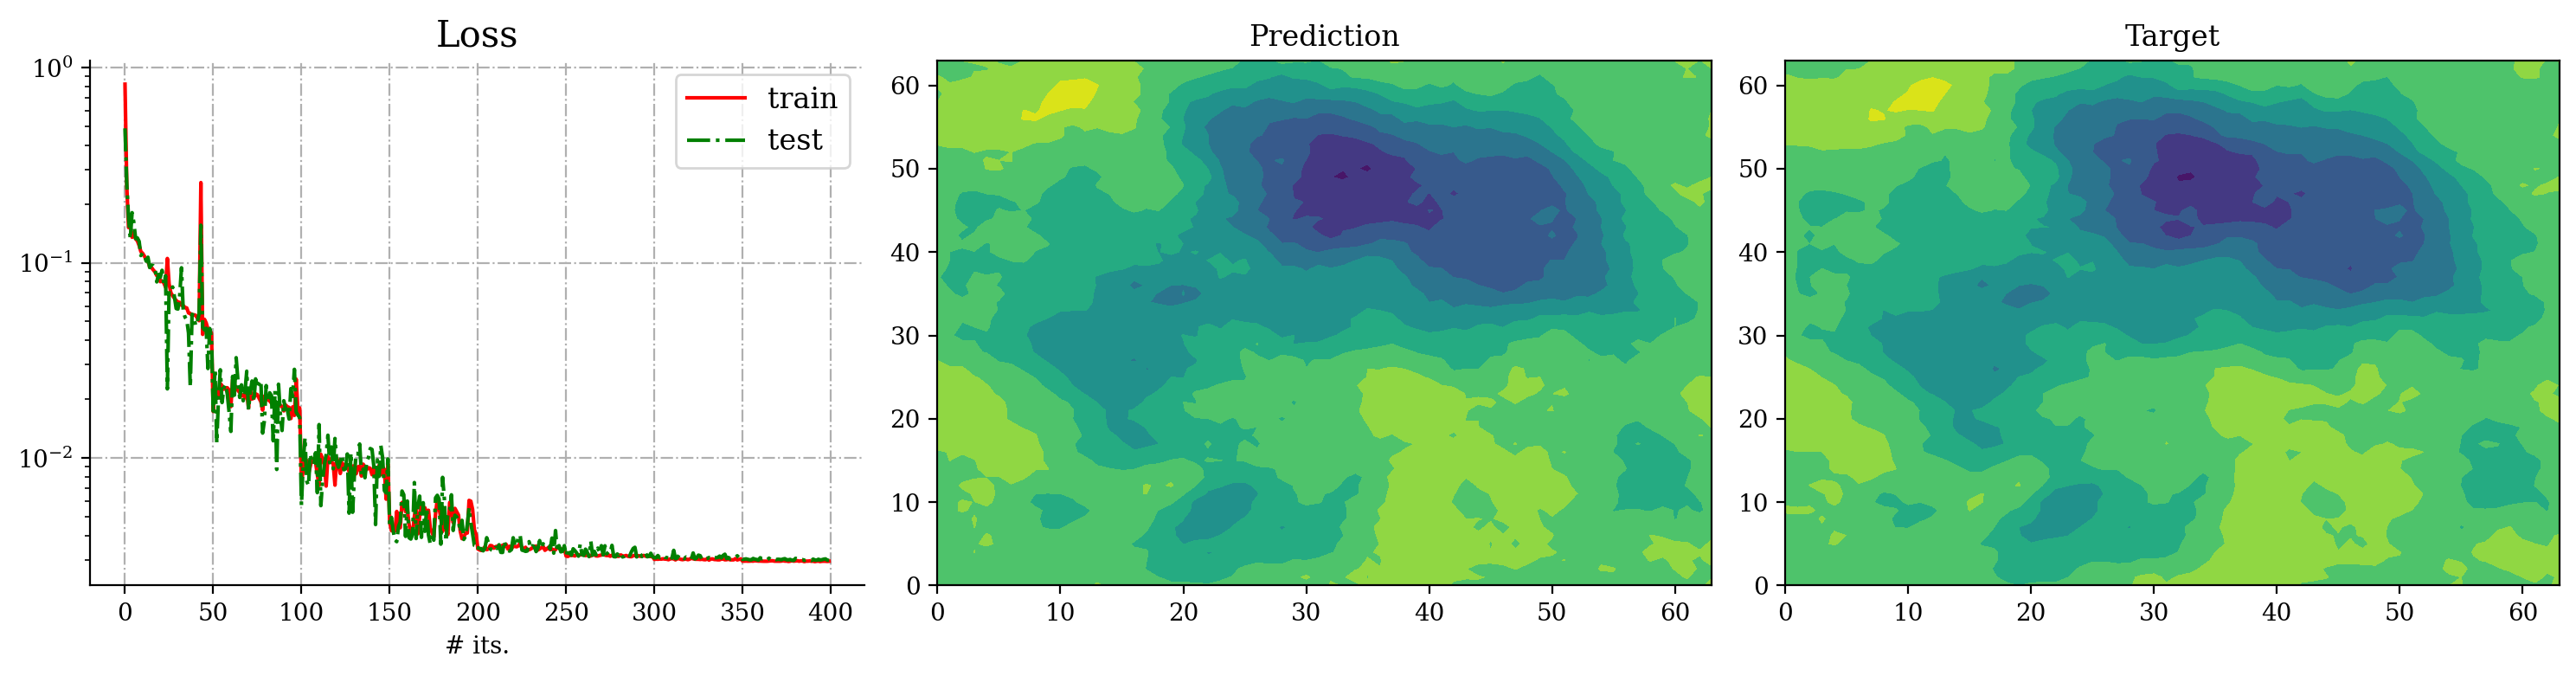

In [10]:
plot_results(model, model_data, data, features_test, targets_test)

In [11]:
model_size = data['model_size']
train_error_mean = jnp.round(data['train_error_mean'], 3)
test_error_mean = jnp.round(data['test_error_mean'], 3)
train_error_std = jnp.round(data['train_error_std'], 3)
test_error_std = jnp.round(data['test_error_std'], 3)

print(f'Model size: {model_size}')
print(f"Train relative error: {train_error_mean} ± {train_error_std}, \nTest relative error: {test_error_mean} ± {test_error_std}")

Model size: 115297
Train relative error: 0.054 ± 0.018000000000000002, 
Test relative error: 0.056 ± 0.018000000000000002
